# Predicting hospital admission at emergency department triage

**Main statement**
Using machine learning, how might we predict the patient admission into the hospital in the emergency department to provide better information that helps the different stakeholders make better decisions.


Welcome to this notebook which focuses on the modeling stage of this data science project. In the previous notebook, it was thoroughly explored and preprocessed the data, and now it will be utilized the resulting 'df_processed' dataframe to build various models. Throughout this notebook, it will be applied the hyperparameters optimization and it will be evaluated the models performance using different metrics. Finally, it will be described the conclusions of the project.

### Notebook Content

- Baseline Model
    - Logistic Regression
- Class imabalance
    - Downsampling / Imbalance learn
- Feature selection
    - Variance Threshold
    - K-best
    - PCA
- Hiperparameter Optimization and Cross Validation
    - Logistic Regression
    - Decision Trees
    - Random forest
    - XGBoost
- Pipelines
    - Logistic Regression
    - Random forest
    - XGBoost
- Final Model Evaluation
    - Scores
    - Area Under the Curve
- Conclusions


**Load the data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px
from scipy import stats

In [2]:
# Load the data
df_processed = pd.read_csv('/Users/ccalderon/Documents/Repositories/df_processed.csv')


In [3]:
# Shape
print(f'The dataframe has {df_processed.shape[0]} rows and {df_processed.shape[1]} columns.')


The dataframe has 534730 rows and 602 columns.


Given the large size of the dataset, this Notebook was built and tested using a 20% sample of the data to speed up the code and allow for quick verification before running the analysis on the entire dataset. The hyperparameter optimization results varied after the first iteration with the full dataset, which helped to fine-tune the parameters before running the final pipelines.

In [4]:
# from sklearn.model_selection import train_test_split

# Split the dataset into sample and remainder sets, with stratification based on the class labels
# df_processed, remainder_df = train_test_split(df_processed_original, test_size=0.8, stratify=df_processed_original['disposition'], random_state=1)



In [5]:
df_processed.shape

(534730, 602)

# Modeling

The task of predicting whether a patient will be admitted or discharged is a binary classification problem, which involves making one of two possible predictions.

There are several machine learning models that can be used to solve binary classification problems like predicting whether a patient will be admitted or discharged. Some popular ones are:

- Logistic Regression
- Decision Trees
- Random Forests
- Support Vector Machines (SVM)
- Naive Bayes
- Neural Networks (e.g., Multi-layer Perceptron)

The choice of model depends on various factors such as the size of the dataset, the complexity of the problem, the interpretability of the model, and the desired level of accuracy. 

It is usually a good practice to try out multiple models and compare their performance to select the best one for the problem at hand.

The df_processed contains more than 500000 rows and more than 600 features (good mix between categorical and numerical columns) , it is a large dataset that could be computationally expensive to train and test depending the model chose. Based on this, to this case it will be explored the following models:

- Logistic Regression: commonly used model for binary classification problems. With a high number of columns there may be many potential interactions and non-linearities among the features. That being said, it's always worth trying logistic regression as a baseline model for comparison purposes, especially if the dataset has a small number of informative features. This model is simple, interpretable, and computationally efficient, and it can serve as a good starting point for model selection.

- Decision Trees: partitioning the data into multiple subsets based on specified cutoff values in the features this model predicts the outcome for each leaf node by using the average outcome of the training data within that particular node.

- Random Forest: This model is known to perform well with large datasets and high-dimensional feature spaces. It can handle a mix of categorical and numerical features, and it's relatively easy to interpret.

- Gradient Boosting (XGBoost): This model is also known to perform well with large datasets and can handle a mix of categorical and numerical features. It's more complex than Random Forests, but it can achieve better performance with careful tuning because is more likely to over-fitting.


## Logistic Regression Model

Previous Assumptions:
- Observations are independent of each other.
- There is no perfect multicollinearity between the independent variables.
- There is a large enough sample size to provide reliable estimates of the coefficients.
- Should not be outliers in the data.
- The errors (residuals) are independent of each other.


In [6]:
# Data
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534730 entries, 0 to 534729
Columns: 602 entries, disposition to whtblooddx
dtypes: float64(202), int64(400)
memory usage: 2.4 GB


In [7]:
# Define the predictor variables
X = df_processed.drop(columns=['disposition'],axis=1).copy()

# Define the target variable
y = df_processed['disposition']

In [8]:
# Import the library
from sklearn.model_selection import train_test_split

# Create the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                 test_size=0.3, 
                                                 random_state=3, 
                                                 stratify=y)

In [9]:
# Logistic regression baseline model
from sklearn.linear_model import LogisticRegression

baseline_logreg = LogisticRegression(solver='lbfgs', max_iter=100000, random_state=1)
baseline_logreg.fit(X_train, y_train)
predictions_train = baseline_logreg.predict(X_train)
predictions_test = baseline_logreg.predict(X_test)
blg_train_accuracy = baseline_logreg.score(X_train, y_train)
blr_test_accuracy = baseline_logreg.score(X_test, y_test)

# Print the accuracy of the model
print(f"Baseline_logred train accuracy: {blg_train_accuracy}")
print(f"Baseline_logreg test accuracy: {blr_test_accuracy}")

Baseline_logred train accuracy: 0.85773861842158
Baseline_logreg test accuracy: 0.8553350912298419


It looks like the model is performing really well, ~86% accuracy. However, remember ~ 30% of patients were admitted and ~70% were discharge, imbalanced data forces us to rely on other evaluation metrics than accuracy: precision, recall, F1 score, and area under the ROC curve to evaluate our model.

**Predictors**

In [10]:
# Logistic Regression Coeficients (remove # too se the coeficients)
# baseline_logreg.coef_

In [11]:
# Define the feature_label and its coefficient
column_labels = X_train.columns.tolist()

# Squeeze function to convert the numpy array into a 1-dimensional array
coef = baseline_logreg.coef_.squeeze().tolist()

In [12]:
# Create a dictionary with column_labels as key and coeficients as values (remove '#' to visualize all the predictors)

lg_predictors = dict(zip(column_labels, coef))
# lg_predictors 

In [13]:
# Top 20 most predictive features by coefficient

sorted_predictors = sorted(lg_predictors.items(), key=lambda x: x[1], reverse=True)
sorted_predictors[:20]

[('esi_1', 2.534205657527735),
 ('cc_respiratorydistress', 1.9791669293153697),
 ('cc_strokealert', 1.3950927620058848),
 ('meds_analgesicandantihistaminecombination', 1.2642724651234627),
 ('cc_follow-upcellulitis', 1.2556146769561956),
 ('meds_blood', 1.2354893398707485),
 ('cc_feverimmunocompromised', 1.2345191189070754),
 ('cc_fever-75yearsorolder', 1.2090707508720426),
 ('cc_fulltrauma', 1.163598375145192),
 ('cc_cellulitis', 1.1517048933066296),
 ('cc_overdose-intentional', 1.1114522684743837),
 ('meds_contraceptives', 1.104714405258871),
 ('esi_2', 1.0208820132240823),
 ('cc_fever-9weeksto74years', 0.9893705863325243),
 ('cc_rectalbleeding', 0.9519777954735752),
 ('cc_neurologicproblem', 0.9511592951439044),
 ('cc_extremityweakness', 0.9460197956056103),
 ('acutphanm', 0.9206945013696161),
 ('cc_dehydration', 0.8967353036043028),
 ('cc_withdrawal-alcohol', 0.8794540882610489)]

The best predictor is esi_1 (emergency severity index 1) which is expected because this index is refering to the patients that the professional considers require attention immediately when the patient is in the triage stage. It is interesting that predictors with higher coefficients are mainly chief complains and some medications groups.  

**Model evaluation**

As was said, class imbalance can cause an issue when training models. Consider the cost function when the model is fitting on the training data. The cost function is going to be biased towards the majority class and will result in a model that doesn't learn enough about the minority class.

Lets see the confusion matrix to evaluate other scores:

In [14]:
# Import the confusion matrix module
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, predictions_test)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Discharge", "Predicted Admitted"],
    index=["True Discharge", "True Admitted"]
)

display(cf_df)

,Predicted Discharge,Predicted Admitted
True Discharge,104306,6696
True Admitted,16511,32906


**Results running the whole dataframe:**

- True Discharge: 104,306 patients were actually discharged and the model correctly predicted that they would be discharged.
- False Admitted: 6,696 patients were actually discharged but the model incorrectly predicted that they would be admitted.
- False Discharge: 16,511 patients were actually admitted but the model incorrectly predicted that they would be discharged.
- True Admitted: 32,906 patients were actually admitted and the model correctly predicted that they would be admitted.

In summary, the model correctly classified 137,212 patients (104,306 true discharge and 32,906 true admitted) and incorrectly classified 23,207 patients (6,696 false admitted and 16,511 false discharge).

In [15]:
# Import the classification_report module
from sklearn.metrics import classification_report

report = classification_report(y_test, predictions_test)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.94      0.90    111002
           1       0.83      0.67      0.74     49417

    accuracy                           0.86    160419
   macro avg       0.85      0.80      0.82    160419
weighted avg       0.85      0.86      0.85    160419



Precision: the precision for class 0.0 is 0.86, which means that 86% of the instances that the model predicted as 0.0 were actually 0.0. Similarly, the precision for class 1.0 is 0.83, indicating that 83% of the instances that the model predicted as 1.0 were actually 1.0.

Recall: the recall for class 0.0 is 0.94, which means that 94% of the actual instances that were 0.0 were correctly predicted by the model. 

F1-score: F1-score for class 0.0 is 0.90, and the F1-score for class 1.0 is 0.74. The weighted average F1-score is 0.85, indicating that the model performed reasonably well in overall.

**The most important here is that recall for class 1.0 is 0.66, indicating that 66% of the actual instances that were 1.0 were correctly predicted by the model. Since that the priority is identify those patients that require be admitted faster it is really necessary correct the imbalance and improve the admitted patients predictions**.

## Class imbalance

To correct the imbalance in this case the approach is going to be downsampling. (A very important note here is that which ever approach will be applied should only be done to the training data, the test data should remain untouched and have class imbalance consistent with what you would expect the real world to be.)

### Downsampling

Downsampling is a method for reducing the size of a dataset by randomly removing observations from the majority class, which can help to balance the class distribution in a binary classification problem. This can be useful when the dataset is imbalanced and the minority class is underrepresented.

In [16]:
from sklearn.utils import resample

print('Number of class 0 examples before:', X_train[y_train == 0].shape[0])

X_downsampled, y_downsampled = resample(X_train[y_train == 0], 
                                        y_train[y_train == 0], 
                                        replace=True, 
                                        n_samples=X_train[y_train == 1].shape[0], 
                                        random_state=123)

print('Number of class 0 examples after:', X_downsampled.shape[0])

# Combine downsample with original data
X_train_bal2 = np.vstack((X_train[y_train == 1], X_downsampled))
y_train_bal2 = np.hstack((y_train[y_train == 1], y_downsampled))

# Convert the X variable numpy array into a dataframe
X_train_bal2 = pd.DataFrame(X_train_bal2, columns=X.columns)

Number of class 0 examples before: 259005
Number of class 0 examples after: 115306


Let's try again the logistic regression model using the downsampled data:

In [17]:
# Logistic regression after downsampling

resample_logreg = LogisticRegression(solver='lbfgs', max_iter=100000, random_state=1)
resample_logreg.fit(X_train_bal2, y_train_bal2)
predictions_train = resample_logreg.predict(X_train_bal2)
predictions_test_ds = resample_logreg.predict(X_test)
resample_train_accuracy = resample_logreg.score(X_train_bal2, y_train_bal2)
test_accuracy = resample_logreg.score(X_test, y_test)

# Print the accuracy of the model
print(f"Baseline_logred train accuracy: {resample_train_accuracy}")
print(f"Baseline_logreg test accuracy: {test_accuracy}")

Baseline_logred train accuracy: 0.8310625639602449
Baseline_logreg test accuracy: 0.8386787101278527


Quite similar accuracy but it is more relevant evaluate recall:

In [18]:
# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, predictions_test_ds)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Discharge", "Predicted Admitted"],
    index=["True Discharge", "True Admitted"]
)

display(cf_df)

,Predicted Discharge,Predicted Admitted
True Discharge,94625,16377
True Admitted,9502,39915


In [19]:
# Logistic Regression Report with downsampling
report_ds = classification_report(y_test, predictions_test_ds)
print(report_ds)

              precision    recall  f1-score   support

           0       0.91      0.85      0.88    111002
           1       0.71      0.81      0.76     49417

    accuracy                           0.84    160419
   macro avg       0.81      0.83      0.82    160419
weighted avg       0.85      0.84      0.84    160419



Remember Logistic Regression Report without downsampling

In [20]:
# Logistic Regression Report without downsampling
report = classification_report(y_test, predictions_test)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.94      0.90    111002
           1       0.83      0.67      0.74     49417

    accuracy                           0.86    160419
   macro avg       0.85      0.80      0.82    160419
weighted avg       0.85      0.86      0.85    160419



Now the model is generating more false admitted patients (Type I error) and less false discharged patients (Type II error), the recall improved but the precision went down. Gladly the overal performance is quite similar ~84%.

### Imbalaced-learn 

Imbalanced-learn (imported as imblearn) is an open source, MIT-licensed library relying on scikit-learn (imported as sklearn) and provides tools when dealing with classification with imbalanced classes. This class does the same that 'resample' but it is easier to implement.

In [21]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print(sorted(Counter(y_resampled).items()))

[(0, 115306), (1, 115306)]


This method was very much easier to fit, now confirm if it is equally performing:

In [22]:
# Logistic regression after downsampling with imbalance learn

resample2_logreg = LogisticRegression(solver='lbfgs', max_iter=100000, random_state=1)
resample2_logreg.fit(X_resampled, y_resampled)
predictions_train = resample2_logreg.predict(X_resampled)
predictions_test_imb = resample2_logreg.predict(X_test)
resample2_train_accuracy = resample2_logreg.score(X_resampled, y_resampled)
test_accuracy = resample_logreg.score(X_test, y_test)

# Print the accuracy of the model
print(f"Baseline_logred train accuracy: {resample2_train_accuracy}")
print(f"Baseline_logreg test accuracy: {test_accuracy}")

Baseline_logred train accuracy: 0.832506547794564
Baseline_logreg test accuracy: 0.8386787101278527


In [23]:
# Logistic Regression Report after using imbalance learn

report_imb = classification_report(y_test, predictions_test_imb)
print(report_imb)

              precision    recall  f1-score   support

           0       0.91      0.85      0.88    111002
           1       0.71      0.81      0.76     49417

    accuracy                           0.84    160419
   macro avg       0.81      0.83      0.82    160419
weighted avg       0.85      0.84      0.84    160419



Compare with downsampling results

In [24]:
# Logistic Regression Report with downsampling
report_ds = classification_report(y_test, predictions_test_ds)
print(report_ds)

              precision    recall  f1-score   support

           0       0.91      0.85      0.88    111002
           1       0.71      0.81      0.76     49417

    accuracy                           0.84    160419
   macro avg       0.81      0.83      0.82    160419
weighted avg       0.85      0.84      0.84    160419



Downsampling or RandomUnderSampler could be indistinctly used to improve the recall of the admitted patients in the model.

**At this point the data to keep working with will be the data downsampled:**

- X_resampled (original X_train after downsampling)
- y_resampled (original y_train after downsampling)
- X_test
- y_test


## Feature selection

Feature selection is the process of selecting a subset of the most important features (variables) from a larger set of available features in a dataset. 

Goal: the most simple model possible with the most predictive power.

There are several approaches to feature selection, regarding this case will be applied:

- Filter methods 

    - Variance Threshold: evaluates the variance of each feature in the dataset and removes those that have a variance below a certain threshold. 
    - K-best: using statistical tests to evaluate the relationship between each feature and the target variable, and then select the top k features based on their scores.

- Dimensionality reduction

    - PCA: reducing the number of features by transforming the original features into a lower-dimensional space while retaining most of the relevant information.

**It is important to carefully evaluate the performance of the selected features on a validation set or through cross-validation to ensure that the final model is robust and generalizable.**

### Variance Threshold

Variance threshold (VT) is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. VT is quite useful to eliminate additional features that don’t provide much value to the model and introduce unnecessary complexity.

The first step is scale the data:

In [25]:
# scaling the data
from sklearn.preprocessing import MinMaxScaler

# Instantiate the scaler
mms = MinMaxScaler()

# Fit the scale the train data 
df_scaled = mms.fit_transform(X_resampled)

# Convert the scaled train arrays to DataFrames
X_resampled_ss = pd.DataFrame(data=df_scaled, columns=X_resampled.columns)

# Scale the test data using the same scaler
X_test_scaled = mms.transform(X_test)

# Convert the scaled test arrays to DataFrames
X_test_ss = pd.DataFrame(data=X_test_scaled, columns=X_test.columns)

Subsequently, create a loop to see how the logistic regression performs with different thresholds:

In [26]:
from sklearn.feature_selection import VarianceThreshold

# Define a list of different variance thresholds to loop over
thresholds = [0.00004, 0.0004, 0.004, 0.04]

# Create empty lists to store the training and test accuracies for each threshold
train_accuracies_th = []
test_accuracies_th = []

# Loop over each threshold value
for th in thresholds:

    # Create a VarianceThreshold object with the current threshold value
    my_vt = VarianceThreshold(threshold=th)

    # Fit the VarianceThreshold object to the training data and calculate the variances per column
    my_vt.fit(X_resampled_ss)
    
    # Use the VarianceThreshold object to drop columns below the given variance threshold
    X_resampled_th = pd.DataFrame(my_vt.transform(X_resampled_ss), columns = X_resampled_ss.columns[my_vt.get_support()])
    
     # Define the predictor variables for the training and test sets
    X_train_th = X_resampled_th
    X_test_th = pd.DataFrame(my_vt.transform(X_test_ss), columns = X_test_ss.columns[my_vt.get_support()])
    
    # Define the target variable for the training and test sets
    y_train_th = y_resampled
    y_test_th = y_test
    
    # Run the model
    
    # Create a logistic regression model and fit it to the training data
    logreg = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1)
    logreg.fit(X_train_th, y_train_th)

    # Use the trained model to make predictions on the training and test sets
    train_predictions = logreg.predict(X_train_th)
    test_predictions = logreg.predict(X_test_th)

    # Calculate the accuracy of the model on the training and test sets
    train_accuracy_th = logreg.score(X_train_th, y_train_th)
    test_accuracy_th = logreg.score(X_test_th, y_test_th)

    # Append the training and test accuracies to their respective lists
    train_accuracies_th.append(train_accuracy_th)
    test_accuracies_th.append(test_accuracy_th)
    

Explore the results with the 4 different thresholds:

In [27]:
# Accuracies with train set and different VTs
train_accuracies_th

[0.8320815915910708,
 0.8319254852306038,
 0.8175506912042738,
 0.7559580594244879]

In [28]:
# Accuracies with test set and different VTs
test_accuracies_th

[0.8385228682387996,
 0.8383607926741845,
 0.8243973594150319,
 0.7462956382972091]

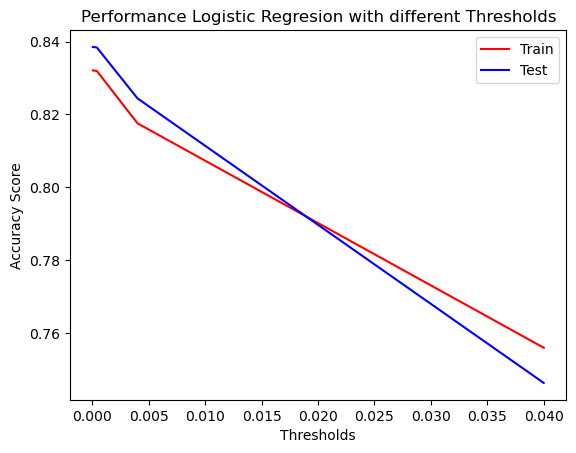

In [29]:
# Visualize the results
plt.plot(thresholds, train_accuracies_th, label='Train', color='red')
plt.plot(thresholds, test_accuracies_th, label='Test', color = 'blue')
plt.title('Performance Logistic Regresion with different Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

The best variance threshold seems to be 0.004, since this information is not enough to chose the best parameter it is necessary to run cross validation to have a more reliable method of selection:

#### **VT Cross Validation**

It is important to carefully evaluate the performance of the selected features on a validation set or through cross-validation to ensure that the final model is robust and generalizable. Because of this, it will be applied cross validation with the different variance thresholds:

In [30]:
from sklearn.model_selection import cross_val_score

# Define the thresholds to test
thresholds = [0.00004, 0.0004, 0.004, 0.04]

# Create empty lists to store the cv scores
cv_scores = []

# Define the logistic regression model
logreg = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1)

# Loop over the thresholds and perform cross-validation
for th in thresholds:
    # Instantiate the VarianceThresholder with the given threshold
    vt = VarianceThreshold(threshold=th)

    # Fit to the data and calculate the variances per column
    vt.fit(X_resampled_ss)

    # Apply the variance threshold to drop columns below the given variance
    X_resampled_th = pd.DataFrame(vt.transform(X_resampled_ss), columns=X_resampled_ss.columns[vt.get_support()])

    # Define the predictor variables
    X_train_th = X_resampled_th

    # Define the target variable
    y_train_th = y_resampled

    # Perform 5-fold cross-validation on the logistic regression model
    cv_score = cross_val_score(logreg, X_train_th, y_train_th, cv=5)
    
    # Append the results
    cv_scores.append(cv_score.mean())

    # Print the average cross-validation score for the current threshold
    print(f"Threshold: {th}, CV Score: {cv_score.mean():.4f}")


Threshold: 4e-05, CV Score: 0.8307
Threshold: 0.0004, CV Score: 0.8307
Threshold: 0.004, CV Score: 0.8170
Threshold: 0.04, CV Score: 0.7557


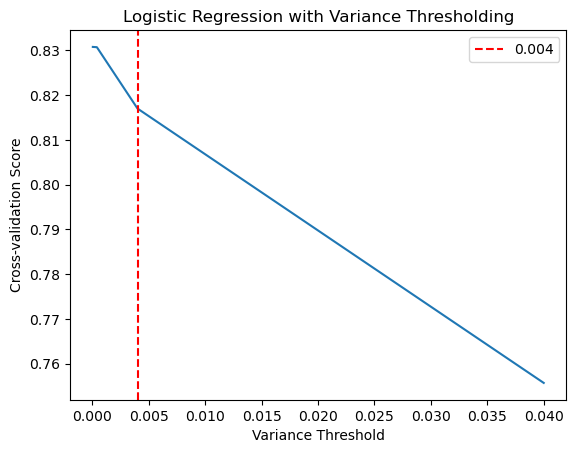

In [31]:
# Plot the cross-validation scores
plt.plot(thresholds, cv_scores)
plt.xlabel('Variance Threshold')
plt.ylabel('Cross-validation Score')
plt.title('Logistic Regression with Variance Thresholding')
plt.axvline(x=0.004, color='r',linestyle='--', label='0.004')
plt.legend()
plt.show()

Great! Cross Validation confirm that <=0.004 threshold could be a good decision to reduce the number of features and keep model performance.

**Fit the best Variance Threshold to generate the new dataframe with the data downsampled and filter based on varianced threshold.**

In [32]:
# Create a VarianceThreshold object with the BEST threshold value
my_vt = VarianceThreshold(threshold=0.004)

# Fit the VarianceThreshold object to the training data and calculate the variances per column
my_vt.fit(X_resampled_ss)

# Use the VarianceThreshold object to drop columns below the given variance threshold
X_resampled_th = pd.DataFrame(my_vt.transform(X_resampled_ss), columns = X_resampled_ss.columns[my_vt.get_support()])

 # Define the predictor variables for the training and test sets
X_train_th = X_resampled_th
X_test_th = pd.DataFrame(my_vt.transform(X_test_ss), columns = X_test_ss.columns[my_vt.get_support()])

# Define the target variable for the training and test sets
y_train_th = y_resampled
y_test_th = y_test

In [33]:
# Get the shape of the new dataframe post Variance Threshold
X_train_th.shape

(230612, 282)

In [34]:
# To get the variances 
my_vt.variances_[:60]

array([0.24487954, 0.2150917 , 0.10199068, 0.24780068, 0.24780068,
       0.09630168, 0.21187065, 0.24578896, 0.10248074, 0.16192685,
       0.19393176, 0.22192124, 0.22098495, 0.19768434, 0.23617735,
       0.15374594, 0.24091239, 0.08992298, 0.07189867, 0.0692279 ,
       0.06338868, 0.07031036, 0.07171562, 0.09148061, 0.0909069 ,
       0.09278657, 0.06501855, 0.06879992, 0.06911358, 0.12288975,
       0.13115786, 0.11596143, 0.11650066, 0.12164062, 0.12527169,
       0.12339942, 0.05526225, 0.14846912, 0.19355533, 0.17838507,
       0.14529719, 0.0808313 , 0.19664175, 0.24388263, 0.20195545,
       0.01399966, 0.23273338, 0.24519475, 0.13718159, 0.02190359,
       0.05393405, 0.00070109, 0.00295159, 0.00792962, 0.00096173,
       0.00038102, 0.02340617, 0.00075764, 0.0023368 , 0.00514214])

In [35]:
# To get the columns which are retained 
my_vt.get_support()[:60]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
       False, False,  True, False, False,  True])

In [36]:
# To get the columns names 
X_train_th.columns.values[:60]

array(['dep_A', 'dep_B', 'dep_C', 'Female', 'Male', 'Divorced', 'Married',
       'Single', 'Widowed', 'Full Time', 'Not Employed', 'Commercial',
       'Medicaid', 'Medicare', 'Car', 'Walk-in', 'ambulance', 'April',
       'August', 'December', 'February', 'January', 'July', 'June',
       'March', 'May', 'November', 'October', 'September', 'Friday',
       'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       '03-06', '07-10', '11-14', '15-18', '19-22', '23-02', 'pv_admit',
       'pv_discharge', 'pv_none', 'esi_1', 'esi_2', 'esi_3', 'esi_4',
       'esi_5', 'age', 'n_surgeries', 'cc_abdominalpain', 'cc_abscess',
       'cc_alcoholintoxication', 'cc_allergicreaction',
       'cc_alteredmentalstatus', 'cc_anklepain', 'cc_armpain',
       'cc_backpain'], dtype=object)

In [37]:
print(f'Applying 0.004 Threshold the final dataframe contains {X_train_th.shape[1]} columns')

Applying 0.004 Threshold the final dataframe contains 282 columns


**Let's confirm how the model perform with the new balanced and reduced dataframe**

In [38]:
# Run the model
    
# Create a logistic regression model and fit it to the training data
logreg = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1)
logreg.fit(X_train_th, y_train_th)

# Use the trained model to make predictions on the training and test sets
train_predictions = logreg.predict(X_train_th)
test_predictions = logreg.predict(X_test_th)

# Calculate the accuracy of the model on the training and test sets
train_accuracy_th = logreg.score(X_train_th, y_train_th)
test_accuracy_th = logreg.score(X_test_th, y_test_th)

# Append the training and test accuracies to their respective lists
print(f' The accuracy in the VT train dataframe is {train_accuracy_th}')
print(f' The accuracy in the VT test dataframe is {test_accuracy_th}')

 The accuracy in the VT train dataframe is 0.8175506912042738
 The accuracy in the VT test dataframe is 0.8243973594150319


**IMPORTANT:** 
- In comparison with the baseline model, logistic Regression after applying downsampling and variance threshold reduce the accuracy in ~ 4% points.
- In comparison with the model after downsampling, Logistic Regression after applying variance threshold reduce the accuracy in ~ 1% points.

**Data post Downsampling, Scaling and 0.004 Variance Threshold:** 

- X_train_th
- y_train_th
- X_test_th
- y_test_th

### K-best

Selects Kbest is a module that select features based on their scores using univariate statistical tests. It takes in a scoring function and a number K as parameters, and then returns the K best features according to the given scoring function.

The scoring function can be:

- f_classif for ANOVA F-value
- mutual_info_classif for mutual information score
- chi2 for chi-squared statistic

As the data in this case has a mix of categorical and numeric features, it will be applied mutual_info_classif to obtain mutual information score depending the feature.

**Remember the data after downsamplig to keep working with the second option to reduce features: K best**

- X_resampled (original X_train after downsampling)
- y_resampled (original y_train after downsampling)
- X_test
- y_test


#### mutual_info_classif

Mutual info classif takes as input the feature matrix and target variable, and returns an array of scores, one for each feature. The score represents the estimated mutual information between the feature and the target variable, and can be used to rank the features by their importance.

Higher mutual_info_classif scores indicate that the feature is more informative for predicting the target variable, while lower scores indicate that the feature is less informative. 

The scores can be used to select a subset of the most important features for the task at hand, or to gain insights into the relationships between the features and the target variable.

In [39]:
# Import the library and classes
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Define the K values 
k_values = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]

# Create the list to store the results
train_scores = []
test_scores = []

# Loop through each k value
for k in k_values:
    # Select top k features using SelectKBest with mutual information as the score function
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    selector.fit(X_resampled, y_resampled)
    X_resampled_top_k = selector.transform(X_resampled)
    X_test_top_k = selector.transform(X_test)
    
    # Train logistic regression model
    clf = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1)
    clf.fit(X_resampled_top_k, y_resampled)
    
    # Calculate train and test scores
    train_score = clf.score(X_resampled_top_k, y_resampled)
    test_score = clf.score(X_test_top_k, y_test)
    
    # Append scores to lists
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print(f"k={k}, train_score={train_score}, test_score={test_score}")


k=100, train_score=0.81944131268104, test_score=0.8299453306653202
k=150, train_score=0.8234957417653895, test_score=0.8316533577693416
k=200, train_score=0.8249006990095918, test_score=0.8328564571528311
k=250, train_score=0.8261799039078626, test_score=0.8353997967821767
k=300, train_score=0.8273203475968293, test_score=0.8344585117722964
k=350, train_score=0.8283263663642829, test_score=0.8358112193692767
k=400, train_score=0.8307893778294277, test_score=0.8372761331263753
k=450, train_score=0.8312923872131546, test_score=0.8380678099227648
k=500, train_score=0.8287122959776595, test_score=0.8350133088973252
k=550, train_score=0.8310495550968726, test_score=0.8371015902106359
k=600, train_score=0.8325369018090992, test_score=0.8387535142345981


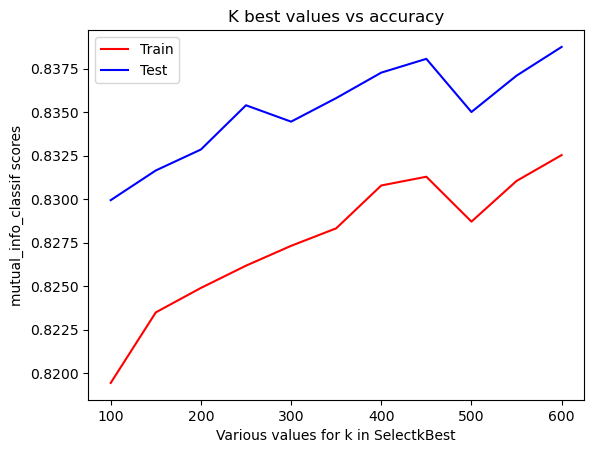

In [40]:
# Visualize the results

plt.plot(k_values, train_scores, label='Train', color='red')
plt.plot(k_values, test_scores, label='Test', color = 'blue')
plt.title('K best values vs accuracy')
plt.xlabel('Various values for k in SelectkBest')
plt.ylabel('mutual_info_classif scores')

plt.legend()
plt.show()

Comparing Variance threshold and Kbest both options are performing quite similar. Including more features increase the model score. However, more features means more computation and training time.

#### Kbest Cross Validation

In [41]:
# Cross Validation to find best Kbest with a higher reduction of features in comparison with Variance threshold

k_values = range(50,400,50)

cv_scores = []

for k in k_values:
    # Select top k features using SelectKBest with mutual information as the score function
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    selector.fit(X_resampled, y_resampled)
    X_resampled_top_k = selector.transform(X_resampled)
    X_test_top_k = selector.transform(X_test)
    
    # Train logistic regression model using 5-fold cross-validation
    clf = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1)
    scores = cross_val_score(clf, X_resampled_top_k, y_resampled, cv=5)
    
    # Calculate mean score across all folds
    cv_score = scores.mean()
    
    cv_scores.append(cv_score)

    print(f"k={k}, mean score={cv_score}")

k=50, mean score=0.8095328887021733
k=100, mean score=0.8173251962459421
k=150, mean score=0.8225851172101948
k=200, mean score=0.8239250243650709
k=250, mean score=0.8256725475175939
k=300, mean score=0.8254297151756449
k=350, mean score=0.8273073305345339


Kbest could be another good option to reduce features, 250 seems to be a good Kbest.

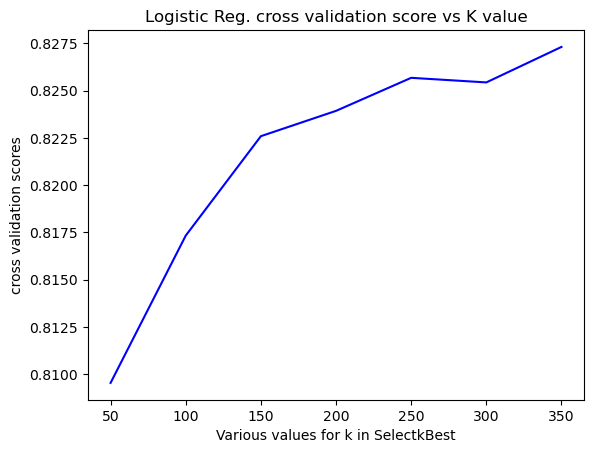

In [42]:
# Visualize the results
plt.plot(k_values, cv_scores, color='blue')
plt.title('Logistic Reg. cross validation score vs K value')
plt.xlabel('Various values for k in SelectkBest')
plt.ylabel('cross validation scores')
plt.show()


### PCA 


Principal Component Analysis (PCA) is a way to transform a high-dimensional dataset into a lower-dimensional representation while retaining as much information as possible.

It will be applied over the data obtained after applied Variance Threshold:
- X_train_th
- y_train_th
- X_test_th
- y_test_th


#### PCA Cross Validation (Variance Threshold df)

Lets see how the model perform with number of components between 50 and 200 having in mind the dataframe after variance threshold contains ~300 columns

In [43]:
from sklearn.decomposition import PCA

# Define range of n_components
n_components = range(50, 200, 5)

# Initialize empty lists to store results
train_scores = []

# Loop through each value of n_components
for n in n_components:
    
    # Initialize PCA with the given number of components
    pca = PCA(n_components=n)

    # Fit PCA on training data and transform both training and testing data
    X_train_pca = pca.fit_transform(X_train_th)

    # Train a logistic regression model on the transformed training data using 5-fold cross validation
    clf = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1)
    scores = cross_val_score(clf, X_train_pca, y_train_th, cv=5)

    # Append mean cross-validation score to train_scores and test score to test_scores
    train_scores.append(np.mean(scores))


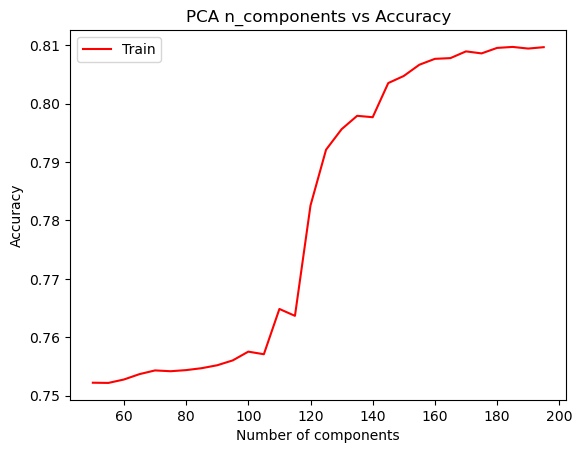

In [44]:
# Plot the results
import matplotlib.pyplot as plt
plt.plot(n_components, train_scores, label='Train', color='red')
plt.title('PCA n_components vs Accuracy')
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


While PCA is a commonly used technique for dimensionality reduction, but in this case it is not providing good accuracy results and was computationally expensive. Additionally, applying PCA lead to a loss of interpretability which in medical predictions is a crucial factor in understanding the model and its predictions. 

## Hiperparameter Optimization (using cross validation)

It will be applied over the data obtained after applied Downsampling, Scaling and Variance Threshold, no PCA:
- X_train_th
- y_train_th
- X_test_th
- y_test_th

### Logistic Regression: C value

In [45]:
# Optimizing C value in Logistic Regression and comparing the results the cross validation with test data

c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000, 10000]

# initialize lists to store cross-validation and test scores
cv_scores = []

# loop over different values of C
for c in c_values:
    # initialize logistic regression model with the given value of C
    lr = LogisticRegression(solver='lbfgs', max_iter=100000, random_state=1, C=c)
    
    # perform cross-validation on the training set
    cv_score = cross_val_score(lr, X_train_th, y_train_th, cv=5)
    cv_scores.append(cv_score.mean())
    
    # fit the logistic regression model on the training set
    lr.fit(X_train_th, y_train_th)


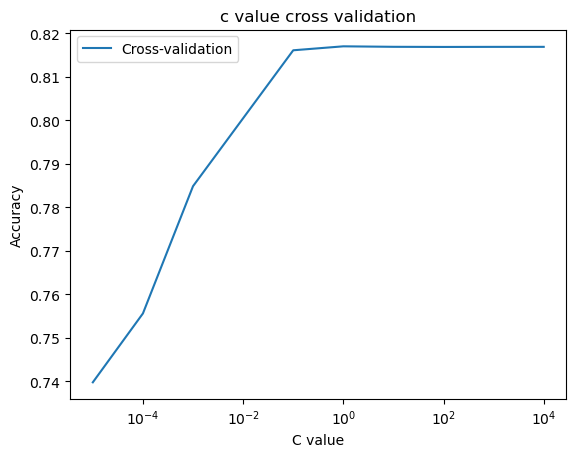

In [46]:
# plot the results of cross-validation and testing
plt.semilogx(c_values, cv_scores, label='Cross-validation')
plt.xlabel('C value')
plt.ylabel('Accuracy')
plt.title('c value cross validation')
plt.legend()
plt.show()

The best C value seems to be 0.1. 

### Decision Trees: Max_depth

In [47]:
from sklearn.tree import DecisionTreeClassifier

# Train and evaluate decision tree models with varying max depths
max_depths = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
cv_scores = []

# Loop in different depths 
for depth in max_depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(clf, X_train_th, y_train_th, cv=5)
    cv_scores.append(scores.mean())

# Find the best-performing model
best_depth = max_depths[cv_scores.index(max(cv_scores))]
print("Best max depth:", best_depth)

# Train the best-performing model on the full training set
clf = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
clf.fit(X_train_th, y_train_th)

# Evaluate the best-performing model on the test set
test_score = clf.score(X_test_th, y_test_th)
print("Test score:", test_score)



Best max depth: 13
Test score: 0.8238238612633166


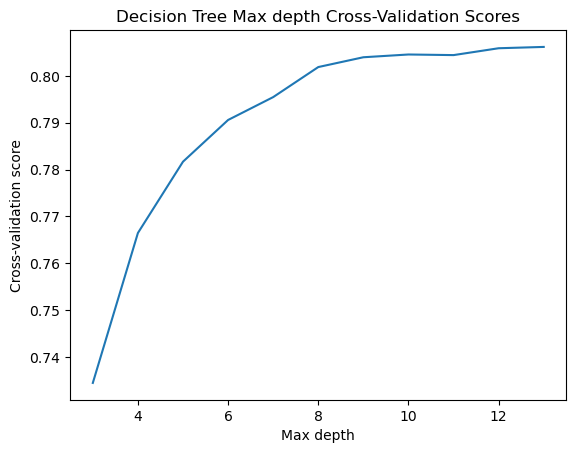

In [48]:
# Plot the results of cross-validation
plt.plot(max_depths, cv_scores)
plt.xlabel("Max depth")
plt.ylabel("Cross-validation score")
plt.title("Decision Tree Max depth Cross-Validation Scores")
plt.show()
 

Best max depth was 13, but 13 was the higher max_depth available, to improve this optimization will be necessary to run again the code with higher numbers for max_depth. However, decision trees will not be deeply explore given there is more interest over random forest and XGBoost.

### Random Forest: n_estimators

In [49]:
from sklearn.ensemble import RandomForestClassifier

# Create an empty list to store the cross validation scores for each n_estimator value
cv_scores = []

# Define n_estimators
n_estimators = range(10, 201, 10)

# Loop over the n_estimator values and calculate the cross validation score for each
for n in n_estimators:
    rf = RandomForestClassifier(max_depth=9, n_estimators=n, random_state=42)
    scores = cross_val_score(rf, X_train_th, y_train_th, cv=5)
    cv_scores.append(scores.mean())


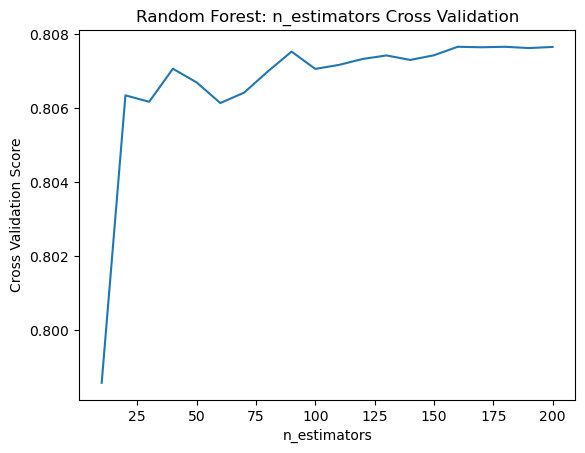

In [50]:
# Plot the results
plt.plot(n_estimators, cv_scores)
plt.xlabel('n_estimators')
plt.ylabel('Cross Validation Score')
plt.title('Random Forest: n_estimators Cross Validation')
plt.show()


In [51]:
# Find the best n_estimator value
# Train the model with the best n_estimator value and predict on the test set
rf = RandomForestClassifier(max_depth=9, n_estimators=125)
rf.fit(X_train_th, y_train_th)
test_score = rf.score(X_test_th, y_test_th)
print(f'Test set score: {test_score}')


Test set score: 0.8290289803576883


Based on this results the random forest pipeline will be built using n_estimators between 100 and 250.

### XGBoost: n_estimators

In [52]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Define the model with the chosen hyperparameters
xgb_model = xgb.XGBClassifier(max_depth=9, learning_rate=0.1)

# Define the range of n_estimators to try
n_estimators_range = range(10, 400, 10)

# Perform cross-validation on the training set for each value of n_estimators
cv_scores = []
for n_estimators in n_estimators_range:
    xgb_model.set_params(n_estimators=n_estimators)
    scores = cross_val_score(xgb_model, X_train_th, y_train_th, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())


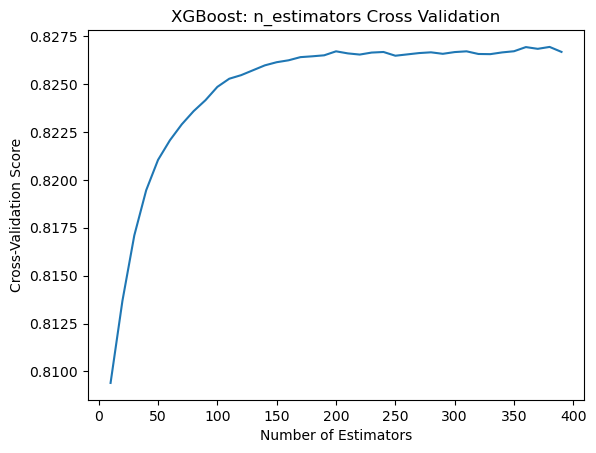

In [53]:
# Plot the results of cross-validation
import matplotlib.pyplot as plt
plt.plot(n_estimators_range, cv_scores)
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-Validation Score')
plt.title('XGBoost: n_estimators Cross Validation')
plt.show()



In [54]:
# Choose the best n_estimators value based on the cross-validation results
best_n_estimators = n_estimators_range[cv_scores.index(max(cv_scores))]
print(f'The best n_estimator was: {best_n_estimators}')

# Train the XGBoost model on the full training set with the best n_estimators value
xgb_model.set_params(n_estimators=best_n_estimators)
xgb_model.fit(X_train_th, y_train_th)

# Evaluate the model on the test set
test_accuracy = xgb_model.score(X_test_th, y_test_th)
print(f"Test accuracy: {test_accuracy}")


The best n_estimator was: 380
Test accuracy: 0.8351255150574434


The best n_estimator was 380 but there is not a significant difference between 150 and 400 n_estimators.

## Pipelines

Now, with a better understanding of the optimal parameters, let's run three pipelines - one for each model - with the goal of identifying the best parameter configuration for each option.

### Logistic Regression Pipe

In [55]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression

# Define the pipeline steps
steps = [
    ('sampling', RandomUnderSampler(random_state=1)),  # optional step, to downsample the majority class
    ('variance_threshold', VarianceThreshold(threshold=0.0004)),  # variance thresholding
    ('logreg', LogisticRegression(solver='lbfgs', max_iter=100000, random_state=1)),  # logistic regression model
]

# Define the parameter grid for the pipeline
param_grid = {
    'sampling': [RandomUnderSampler()],  # with downsampling to improve recall
    'variance_threshold__threshold': [0.0004, 0.004],  # two different variance thresholds
    'logreg__C': [0.1, 1, 10],  # three different values of C for logistic regression
}

# Define the pipeline object
pipe = Pipeline(steps)

# Run the pipeline with grid search to find the best parameters
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(pipe, param_grid, cv=5, verbose = 7)
grid.fit(X_train, y_train)

# Evaluate the best pipeline on the test set
from sklearn.metrics import accuracy_score

y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.3f}")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END logreg__C=0.1, sampling=RandomUnderSampler(), variance_threshold__threshold=0.0004;, score=0.840 total time= 1.5min
[CV 2/5] END logreg__C=0.1, sampling=RandomUnderSampler(), variance_threshold__threshold=0.0004;, score=0.839 total time= 1.5min
[CV 3/5] END logreg__C=0.1, sampling=RandomUnderSampler(), variance_threshold__threshold=0.0004;, score=0.839 total time= 1.5min
[CV 4/5] END logreg__C=0.1, sampling=RandomUnderSampler(), variance_threshold__threshold=0.0004;, score=0.838 total time= 1.3min
[CV 5/5] END logreg__C=0.1, sampling=RandomUnderSampler(), variance_threshold__threshold=0.0004;, score=0.840 total time= 1.2min
[CV 1/5] END logreg__C=0.1, sampling=RandomUnderSampler(), variance_threshold__threshold=0.004;, score=0.838 total time=  48.7s
[CV 2/5] END logreg__C=0.1, sampling=RandomUnderSampler(), variance_threshold__threshold=0.004;, score=0.837 total time=  34.1s
[CV 3/5] END logreg__C=0.1, sampling=Ra

In [56]:
# Get the best pipeline and its parameters
best_pipe = grid.best_estimator_
best_params = grid.best_params_

# Print the best parameters
print(f"Best parameters: {best_params}")

Best parameters: {'logreg__C': 0.1, 'sampling': RandomUnderSampler(), 'variance_threshold__threshold': 0.0004}


### Random Forest Pipe

In [57]:
# Define the pipeline steps
steps = [
    ('sampling', RandomUnderSampler()),  # to downsample the majority class
    ('variance_threshold', VarianceThreshold()),  # variance thresholding
    ('random_forest', RandomForestClassifier())  # random forest model
]

# Define the parameter grid for the pipeline
param_grid = {
    'sampling': [RandomUnderSampler(random_state=1)],  # with downsampling
    'variance_threshold__threshold': [0.004],  # variance threshold
    'random_forest__max_depth': [8, 9, 10, 11],  # four different max_depth values for random forest
    'random_forest__n_estimators': [100, 150, 200, 250],  # four different n_estimators values for random forest
}

# Define the pipeline object
pipeline = Pipeline(steps=steps)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    pipeline, param_grid=param_grid, cv=5, scoring='accuracy', verbose=7
)

# Fit the pipeline to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

# Evaluate the best pipeline on the test set
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.3f}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END random_forest__max_depth=8, random_forest__n_estimators=100, sampling=RandomUnderSampler(random_state=1), variance_threshold__threshold=0.004;, score=0.835 total time=  13.7s
[CV 2/5] END random_forest__max_depth=8, random_forest__n_estimators=100, sampling=RandomUnderSampler(random_state=1), variance_threshold__threshold=0.004;, score=0.837 total time=  13.4s
[CV 3/5] END random_forest__max_depth=8, random_forest__n_estimators=100, sampling=RandomUnderSampler(random_state=1), variance_threshold__threshold=0.004;, score=0.836 total time=  13.4s
[CV 4/5] END random_forest__max_depth=8, random_forest__n_estimators=100, sampling=RandomUnderSampler(random_state=1), variance_threshold__threshold=0.004;, score=0.835 total time=  13.5s
[CV 5/5] END random_forest__max_depth=8, random_forest__n_estimators=100, sampling=RandomUnderSampler(random_state=1), variance_threshold__threshold=0.004;, score=0.841 total time=  13.5s

In [58]:
# Get the best pipeline and its parameters
best_pipeline = grid_search.best_estimator_
best_params = best_pipeline.get_params()

# Print the best parameters
print("Best pipeline parameters:")
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_params[param_name]}")

Best pipeline parameters:
	random_forest__max_depth: 11
	random_forest__n_estimators: 100
	sampling: RandomUnderSampler(random_state=1)
	variance_threshold__threshold: 0.004


### XGBoost Pipe

In [63]:
# Import the library to use this model
from xgboost import XGBClassifier

# Define the pipeline steps
steps = [
    ('undersample', RandomUnderSampler()),
    ('variance_threshold', VarianceThreshold()),
    ('classifier', XGBClassifier())
]

# Define the parameter grid for the pipeline
param_grid = {
    'undersample__sampling_strategy': ['auto'],
    'variance_threshold__threshold': [0.0004],
    'classifier__max_depth': [11, 20],
    'classifier__n_estimators': [150, 200],
    'classifier__learning_rate': [0.1]
}

# Define the pipeline object
pipeline = Pipeline(steps=steps)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose = 7
)

# Fit the pipeline to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

# Evaluate the best pipeline on the test set
from sklearn.metrics import accuracy_score

y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.3f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 2/5] END classifier__learning_rate=0.1, classifier__max_depth=11, classifier__n_estimators=150, undersample__sampling_strategy=auto, variance_threshold__threshold=0.0004;, score=0.847 total time=48.8min
[CV 2/5] END classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=150, undersample__sampling_strategy=auto, variance_threshold__threshold=0.0004;, score=0.843 total time=72.5min
[CV 2/5] END classifier__learning_rate=0.1, classifier__max_depth=11, classifier__n_estimators=200, undersample__sampling_strategy=auto, variance_threshold__threshold=0.0004;, score=0.846 total time=61.9min
[CV 4/5] END classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=150, undersample__sampling_strategy=auto, variance_threshold__threshold=0.0004;, score=0.842 total time=69.3min
[CV 1/5] END classifier__learning_rate=0.1, classifier__max_depth=11, classifier__n_estimators=200, undersample_

In [64]:
# Get the best pipeline and its parameters
best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters
print("Best parameters: ", best_params)

Best parameters:  {'classifier__learning_rate': 0.1, 'classifier__max_depth': 11, 'classifier__n_estimators': 150, 'undersample__sampling_strategy': 'auto', 'variance_threshold__threshold': 0.0004}


In [65]:
# Get more details
grid_search.best_estimator_

Pipeline(steps=[('undersample', RandomUnderSampler()),
                ('variance_threshold', VarianceThreshold(threshold=0.0004)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None,...None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=11, max_leaves=None,
                               min_child_weight=None, missing=na

## Final Model Evaluation

### Scores

The last part will be define three different pipelines for the three models: logistic regression, random forest, and XGBoost with the optimal hyperparameters determined from a previous step. It will be obtained the classification_report to print out a report of precision, recall, and F1-score for each model's predictions on the test data and compare the best the models.

In [73]:
# Import  make_imb_pipeline to be sure the pipeline is going to perform the Downsampling before any other step.
from imblearn.pipeline import make_pipeline as make_imb_pipeline


# Define pipeline for Logistic Regression
logreg_pipe = make_imb_pipeline(
    RandomUnderSampler(),
    VarianceThreshold(threshold=0.0004),
    LogisticRegression(solver='lbfgs', max_iter=100000, random_state=1, C=0.1)
)

# Define pipeline for Random Forest
rf_pipe = make_imb_pipeline(
    RandomUnderSampler(),
    VarianceThreshold(threshold=0.004),
    RandomForestClassifier(max_depth=11, n_estimators=100, random_state=1)
)

# Define pipeline for XGBoost
xgb_pipe = make_imb_pipeline(
    RandomUnderSampler(),
    VarianceThreshold(threshold=0.0004),
    XGBClassifier(max_depth=11, n_estimators=150, learning_rate=0.1, random_state=1)
)

# Fit each pipeline on the data
logreg_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)
xgb_pipe.fit(X_train, y_train)

# Print classification report for each pipeline
print("Logistic Regression:")
print(classification_report(y_test, logreg_pipe.predict(X_test)))

print("Random Forest:")
print(classification_report(y_test, rf_pipe.predict(X_test)))

print("XGBoost:")
print(classification_report(y_test, xgb_pipe.predict(X_test)))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88    111002
           1       0.71      0.81      0.76     49417

    accuracy                           0.84    160419
   macro avg       0.81      0.83      0.82    160419
weighted avg       0.85      0.84      0.84    160419

Random Forest:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88    111002
           1       0.72      0.76      0.74     49417

    accuracy                           0.84    160419
   macro avg       0.81      0.81      0.81    160419
weighted avg       0.84      0.84      0.84    160419

XGBoost:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88    111002
           1       0.72      0.81      0.76     49417

    accuracy                           0.85    160419
   macro avg       0.82      0.84      0.82    160419
weighted avg       0.85      

The classification report shows the model results in terms of precision, recall and f1-score when test data was used.

All three models had almost the same accuracy score of 0.84 (correct predictions over the total number of predictions). 
However, the precision, recall, and f1-score for the two classes are slightly different for each model.

- Logistic Regression has the highest precision for class 0 at 0.91, but a lower precision of 0.71 for class 1. Higher precision means lower number of false positives. This model has a good recall, it is predicting 81% of the total admitted patients.

- Random Forest has similar precision for both classes, but the recall is considerably lower for class 1 this means the model can be missing important admitted cases, leading to serious consequences for the patients.

- XGBoost performs slightly better than logistic regression and random forest, especially regarding recall but the differences are relatively small.

Overall, the results suggest that XGBoost performs slightly better than logistic regression and random forest, particularly for class 1.  Nevertheless, considering interpretability, training time, and computational resources logistic regression is much better, since that XGBoost required more computational resources and longer training time.

### Area Under the ROC Curve

The AUC (Area Under the ROC Curve) is a quality binary classification model metric. The AUC score ranges between 0 and 1, with a higher score indicating a better model. Can be interpreted as the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one.

In [74]:
from sklearn.metrics import roc_auc_score

# Calculate AUC for Logistic Regression pipeline
logreg_auc = roc_auc_score(y_test, logreg_pipe.predict_proba(X_test)[:, 1])
print("Logistic Regression AUC:", logreg_auc)

# Calculate AUC for Random Forest pipeline
rf_auc = roc_auc_score(y_test, rf_pipe.predict_proba(X_test)[:, 1])
print("Random Forest AUC:", rf_auc)

# Calculate AUC for XGBoost pipeline
xgb_auc = roc_auc_score(y_test, xgb_pipe.predict_proba(X_test)[:, 1])
print("XGBoost AUC:", xgb_auc)

Logistic Regression AUC: 0.9146128380620309
Random Forest AUC: 0.9018399155876042
XGBoost AUC: 0.9206397416382726


According AUC results XGBoost model has the highest AUC score (0.92), followed by the Logistic Regression model (0.91), and then the Random Forest model (0.90).

It is important to note that the AUC score alone is not enough to determine the overall performance of a classification model, this metric is only a complement of precision, recall, and F1-score.

## Conclusions

Model Performance: The results suggest that XGBoost performs slightly better than logistic regression and random forest, particularly for class 1.  Nevertheless, considering interpretability, training time, and computational resources logistic regression is much better, since that XGBoost required more computational resources and longer training time.

Feature Importance: Predictors with higher coefficients are mainly emergency severity index, chief complains and some medications groups. However, include information about demographics and past medical history improve the model performance, this was demonstrated when reducing the number of variables included in the model reduce the overall model accuracy. Additionally, two big groups of data were dropped during preprocessing steps: triage data and past medical history data, for future models include this information have a potential to improve the model performance.

Model Interpretation: Overall, logistic regression provides coefficients that can be easily interpreted, while random forest and XGBoost provide importance measures that rank the importance of predictor variables. It could be said that the 3 models have a good degree of interpretability.

Generalizability: The fact that the language and clinical practice are standardized offers great advantages when it comes to generalizing these results and expecting similar results using new information.

Limitations: Hospitals face challenges in integrating disparate data sources, ensuring data quality, and protecting patient privacy when using predictive models. Implementing predictive models can also be disruptive and expensive, requiring infrastructure and technical expertise.   

Future Directions: The results suggested that increasing the amount of data can improve the predictive performance of a model. However, it is also important to note that a high level of dimensionality in the independent variables can increase model complexity and computational expenses. To address this, future models could consider grouping chief complaints and past medical history features into categories to evaluate model performance and increase the practical applicability of the models in real-world scenarios.

Conclusion: Using machine learning to improve decision-making in hospitals at all levels has the potential to greatly reduce costs related to medical errors and resource distribution, thereby improving not only financial outcomes but also satisfaction among different groups, including patients, healthcare workers, and management agents.

**END**